In [186]:
from multi_scale_edge_detection.MultiScaleContourDetector import multi_scale_contour_detection_with_inhibition, multi_scale_contour_detection_without_inhibition
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [187]:


def preprocess_image(image):
    # Use Canny edge detector to find edges
    edges = multi_scale_contour_detection_with_inhibition(image, N=4, sigma=1, alpha=0.001)
    
    return edges



def assign_direction_vectors(edges, threshold = 0.5):
    # Compute the gradient in the x and y direction
    grad_x = cv2.Sobel(edges, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(edges, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute the gradient magnitude and direction
    magnitude, angle = cv2.cartToPolar(grad_x, grad_y)
    
    # Initialize arrays to store direction vector components for each pixel
    direction_vectors_x = np.zeros_like(edges, dtype=np.float64)
    direction_vectors_y = np.zeros_like(edges, dtype=np.float64)

    # Calculate direction vector for each pixel
    for i in range(edges.shape[0]):  # Iterate over rows
        for j in range(edges.shape[1]):  # Iterate over columns
            angle_rad = angle[i, j]
            mag = magnitude[i, j]
            if mag > threshold and angle_rad > 0 :
                x_component = mag * np.cos(angle_rad)
                y_component = mag * np.sin(angle_rad)
                direction_vectors_x[i, j] = x_component
                direction_vectors_y[i, j] = y_component
    ## combine the direction vectors
    image_directions = np.stack((direction_vectors_x, direction_vectors_y), axis=2)

    ## filter thenidrection vectore where the norm is 0
    image_directions = image_directions[np.linalg.norm(image_directions, axis=2) > 0]

    return image_directions



# Example usage
image = cv2.imread('database/images/rino.pgm', cv2.IMREAD_UNCHANGED)  # Replace with your image path
edges = preprocess_image(image)
model = assign_direction_vectors(edges, threshold=0.5)




In [188]:

def cosine_similarity(vector_a, vector_b):
    """
    Calculate the cosine similarity between two vectors.
    
    Parameters:
    - vector_a: First vector (numpy array).
    - vector_b: Second vector (numpy array).
    
    Returns:
    - similarity: Cosine similarity between vector_a and vector_b.
    """
    dot_product = np.dot(vector_a, vector_b)
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

def model_image_similarity( model_directions,  image_directions):
    """
    Compute the similarity measure between a model and an image based on points and associated direction vectors.
    
    Parameters:
    - model_directions: List of direction vectors (numpy arrays) for the model points.
    - image_directions: List of direction vectors (numpy arrays) for the image points.
    
    Returns:
    - average_similarity: The average cosine similarity between corresponding direction vectors of model and image points.
    """
    similarities = []
    for i in range(model_directions.shape[0]):
        for j in range(model_directions.shape[1]):
            similarity = cosine_similarity(model_directions[i][j], image_directions[i][j])
            similarities.append(similarity)
    
    average_similarity = np.mean(similarities)
    return average_similarity


In [189]:
def template_matching(template, target):
    # Find template dimensions
    th, tw = template.shape[:2]

    # Compute the barycenter of the target image
    ty, tx = target.shape[:2]
    barycenter_x = tx // 2
    barycenter_y = ty // 2

    # Compute the size of the ROI
    roi_size_x = tw * 2
    roi_size_y = th * 2

    # Define the ROI boundaries
    roi_x = max(0, barycenter_x - roi_size_x // 2)
    roi_y = max(0, barycenter_y - roi_size_y // 2)
    roi_width = min(tx - roi_x, roi_size_x)
    roi_height = min(ty - roi_y, roi_size_y)
    edge_template = preprocess_image(template)
    model_temp = assign_direction_vectors(edge_template)

    # Slide template over the target image within the ROI and calculate similarity scores
    best_similarity = 0.0
    best_location = None
    for y in range(roi_y, roi_y + roi_height - th):
        for x in range(roi_x, roi_x + roi_width - tw ):
            roi = target[y:y+th, x:x+tw]
            edge_roi = preprocess_image(roi)
            model_roi = assign_direction_vectors(edge_roi)
            similarity = model_image_similarity(model_temp, model_roi)
            if similarity > best_similarity:
                best_similarity = similarity
                best_location = (x, y)
                print(best_similarity)
                print(best_location)


    return best_location


In [190]:
import cv2

# Path to the video file
video_path = 'boat.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

# Initialize an empty list to store frames
frames = []

# Read the video frame by frame
while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame was successfully read
    if not ret:
        break

    # Append the frame to the frames list
    frames.append(frame)

# Release the video capture object
cap.release()

# Convert the list of frames to a numpy array
frames_array = np.array(frames)

# Print the shape of the frames array
print("Shape of frames array:", frames_array.shape)


Shape of frames array: (300, 720, 1280, 3)


In [191]:
normalized_frames = []

# Iterate over each frame array
for frame in frames_array:
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Normalize the pixel values to range [0, 1]
    normalized_frame = gray_frame / 255.0
    
    # Append the normalized grayscale frame to the list
    normalized_frames.append(normalized_frame)

print("Normalization and storing completed.")

Normalization and storing completed.


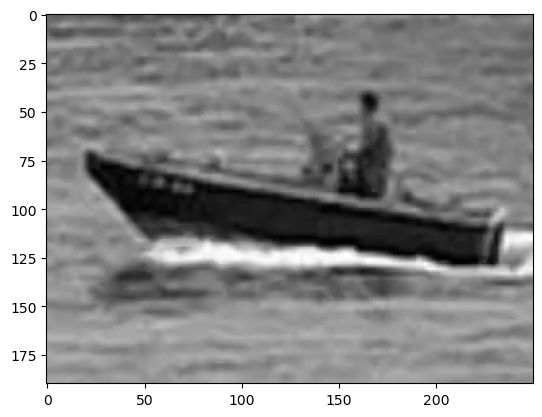

In [192]:
temp1 = normalized_frames[0][260:450,450:700]

plt.imshow(temp1, cmap="gray")


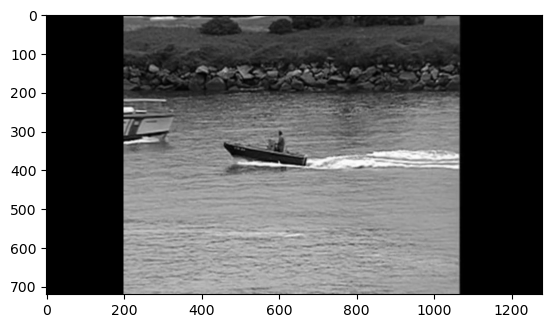

In [193]:
plt.imshow(normalized_frames[10], cmap="gray")    

In [194]:
if __name__ == "__main__":
    # Load images
    template_img = temp1
    target_img = normalized_frames[10]

    # Find the best location for template matching
    best_loc = template_matching(template_img, target_img)

    # Draw rectangle around the matched region
    tw, th = template_img.shape[:2]
   # Draw rectangle around matched region
plt.imshow(target_img, cmap="gray")   # Convert BGR to RGB for matplotlib
plt.gca().add_patch(plt.Rectangle((best_loc[0], best_loc[1]), tw, th, edgecolor='g', linewidth=2, fill=False))
plt.show()

0.005784708249496982
(390, 170)
0.008551307847082495
(391, 170)
0.024396378269617706
(392, 170)
0.03118712273641851
(394, 170)
0.035211267605633804
(405, 170)
0.03747484909456741
(416, 170)
0.0460261569416499
(441, 170)
0.05306841046277666
(452, 170)
0.059356136820925554
(399, 171)


KeyboardInterrupt: 

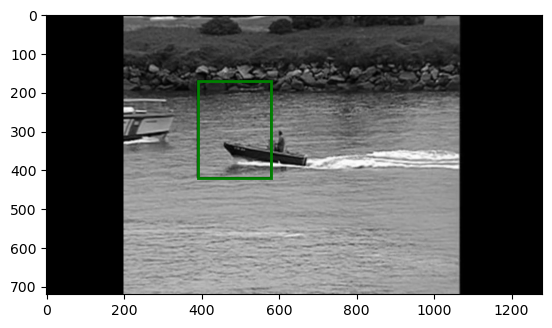

In [ ]:
best_loc[0]

